In [1]:
import datajoint as dj
dj.config['database.host'] = 'datajoint.it.ntnu.no'
dj.conn().connect()

Connecting thinh@datajoint.it.ntnu.no:3306


In [2]:
dj.config['display.limit'] = 5

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
animal = dj.create_virtual_module('animal', 'prod_mlims_data')
reference = dj.create_virtual_module('reference', 'group_shared_reference')
acquisition = dj.create_virtual_module('acquisition', 'group_shared_acquisition')
tracking = dj.create_virtual_module('tracking', 'group_shared_tracking')
behavior = dj.create_virtual_module('behavior', 'group_shared_behavior')
ephys = dj.create_virtual_module('ephys', 'group_shared_ephys')
analysis = dj.create_virtual_module('analysis', 'group_shared_analysis')
analysis_param = dj.create_virtual_module('analysis_param', 'group_shared_analysis_param')

# Getting familiar with the analysis pipeline

## Recap

With the ephys data, tracking data, and clustering results ingested into the pipeline, it is now time to take a look at the analyses performed on the ingested data.

Just to recap, the diagram below shows a quick summary on the "things" present at the end of the ingestion routine.

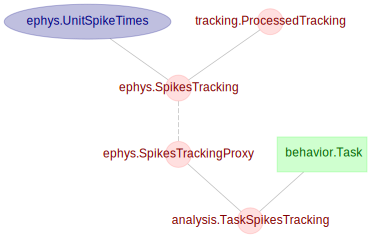

In [5]:
dj.Diagram(ephys.SpikesTracking) + analysis.TaskSpikesTracking + behavior.Task + tracking.ProcessedTracking + ephys.UnitSpikeTimes

The ***ephys.SpikesTracking*** and ***ephys.SpikesTrackingProxy*** really refer to the same information: ***Spikes-Tracking***

The present of both is to overcome a technical limitation of MySQL - only allowing for a maximum of 16 attributes as primary key

As the name suggested, ***ephys.SpikesTrackingProxy*** is really just a proxy table to the ***ephys.SpikesTracking***, condensing the long list of primary attributes.

## The *dj.Computed* table

You probably wonder what are those red, blue, green color-code tables. As briefly introduced on day 1, DataJoint classifies tables into 4 primary tiers:
+ Lookup
+ Manual
+ Imported
+ Computed

More details on table tier here: https://docs.datajoint.io/python/definition/05-Data-Tiers.html

***Computed*** tables are those with contents automatically computed/populated based on the data coming from the parent tables above, without needing any additionally information externally (e.g. from files somewhere)

This means the contents in ***Computed*** tables can be deleted and recomputed relatively easily, since all the required info/data should already be present entirely in the pipeline (e.g. in the upstream parent tables)

The code implementation of these analysis tables are based on the MATLAB BNT toolbox, translated over in Python

## Overview of the analysis pipeline

The ***analysis.TaskSpikesTracking*** is the beginning point of all the downstream analyses

As you can see, these tables here are of type ***computed table*** - denoted in red. This just means that the contents for these tables are automatically populated/computed based on the data coming from the parent tables above. 

The script 

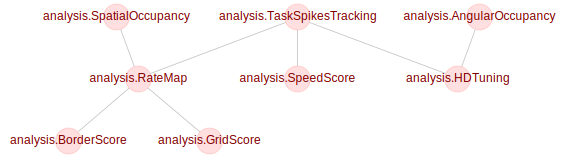

In [6]:
dj.Diagram(analysis.TaskSpikesTracking) + 2 + analysis.SpatialOccupancy + analysis.AngularOccupancy - analysis.ShuffledScores - analysis.RateMap.FiringFields - analysis.ScoreSummary

The diagram above shows a simplified structure of the analysis pipeline. Starting from the spike times and tracking information in a given task, the following analyses are automatically performed:
+ Spatial Occupancy
+ Rate Map
+ Angular Occupancy
+ Head Direction Tuning
+ Border Score
+ Grid Score
+ Speed Score

## Spatial Occupancy

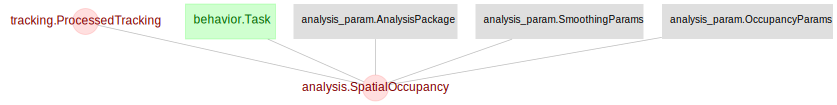

In [7]:
dj.Diagram(analysis.SpatialOccupancy) - 1

We can display the definition of the table with ***.describe()***

In [8]:
analysis.SpatialOccupancy.describe();

-> behavior.Task
-> tracking.ProcessedTracking
-> analysis_param.OccupancyParams
-> analysis_param.SmoothingParams
-> analysis_param.AnalysisPackage
---
spatial_occupancy    : longblob                     # Smoothed 2D occupancy map             # map.time
spatial_occupancy_mask : longblob                     # Mask (where time = 0)                 # isnan(map.timeRaw)
spatial_occupancy_raw : longblob                     # Raw, non-smoothed 2D occupancy map    # map.timeRaw
x_edges              : longblob                     # Histogram edges in x                  # map.x
y_edges              : longblob                     # Histogram edges in y                  # map.y
coverage             : float                        # fraction of the arena the animal covered



The `---` separates between primary (above) and non-primary (below) attributes, typically can be thought of as: 
+ the "things" needed to perform the computation 
+ the results of the computation

***analysis.SpatialOccupancy*** directly depends on:
+ Task
+ Processed Tracking (positions)
+ Set of parameters for computation:
    + Occupancy parameter set
    + Smoothing parameter set
+ Analysis Package: MATLAB or Python

In [9]:
analysis.SpatialOccupancy()

animal_id,datasource_id,session_time start time of this session,task_type,task_start (s) timestamp of task onset with respect to the start of the session,tracking_time start time of this tracking recording,tracking_processing_method,sync_method sync method name,"occu_params_name Parameter set ID, starting with 'default'",smoothing_params_name,analysis_package,spatial_occupancy Smoothed 2D occupancy map # map.time,spatial_occupancy_mask Mask (where time = 0) # isnan(map.timeRaw),"spatial_occupancy_raw Raw, non-smoothed 2D occupancy map # map.timeRaw",x_edges Histogram edges in x # map.x,y_edges Histogram edges in y # map.y,coverage fraction of the arena the animal covered
40bfa03a7a7018cc,0,2019-09-17 19:43:06,OpenField,45.00,2019-09-17 19:42:39,3d_optitrack,linear_interp,default,default,python,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,0.00015625
61fd2ac184c13c73,0,2017-10-02 15:54:25,OpenField,0.00,2017-10-02 15:54:25,2d_2led,presync,default,default,python,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,0.995117
61fd2ac184c13c73,0,2018-01-02 11:20:23,OpenField,0.00,2018-01-02 11:20:23,2d_2led,presync,default,default,python,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,0.995117
6a61369265b193e8,0,2017-09-08 14:58:22,OpenField,0.00,2017-09-08 14:58:22,2d_2led,linear_interp,default,default,python,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,0.543945
6a61369265b193e8,0,2017-09-08 14:58:22,PhotoStim,1104.00,2017-09-08 15:16:46,2d_2led,linear_interp,default,default,python,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,0.422852


In [10]:
sp_occu = (analysis.SpatialOccupancy & 'session_time = "2017-10-02 15:54:25"').fetch1('spatial_occupancy')

In [11]:
sp_occu

array([[3.03733945, 2.85750174, 2.54427401, ..., 2.94606253, 3.30994395,
        3.50953663],
       [2.81042148, 2.67577043, 2.43649525, ..., 2.89748873, 3.20703341,
        3.37087577],
       [2.4215482 , 2.35691185, 2.23147398, ..., 2.81712752, 3.04139377,
        3.14787538],
       ...,
       [3.58178062, 3.35394599, 2.94301819, ..., 1.66813717, 1.80647398,
        1.87687618],
       [3.90428083, 3.64605207, 3.18080495, ..., 1.82943715, 1.98533543,
        2.06310226],
       [4.07676   , 3.79815753, 3.29726753, ..., 1.90593214, 2.0683594 ,
        2.14849612]])

In [12]:
sp_occu.shape

(32, 32)

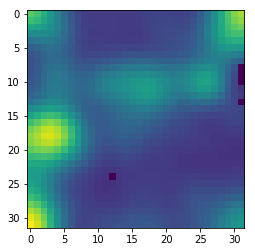

In [13]:
plt.imshow(sp_occu)

## Rate Map

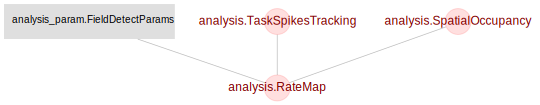

In [14]:
dj.Diagram(analysis.RateMap) - 1

In [15]:
analysis.RateMap.describe();

-> analysis.TaskSpikesTracking
-> analysis.SpatialOccupancy
-> analysis_param.FieldDetectParams
---
ratemap              : longblob                     # Smoothed 2D ratemap     # 1     map.z
ratemap_mask         : longblob                     # Mask (where time = 0)   # 1     isnan(map.zRaw)
ratemap_raw          : longblob                     # Unsmoothed ratemap     # 1      map.zRaw
fieldmap             : longblob                     # 2     fieldsMap
field_quantity       : smallint                     # 2     size(fields)
peak_rate=null       : float                        
mean_rate=null       : float                        # 4
spatial_information_rate=null : float                        # 3     information.rate
spatial_information_content=null : float                        # 3     information.content
spatial_coherence=null : float                        # 5     coherence
selectivity=null     : float                        # 3     selectivity
sparsity=null        : float         

***analysis.RateMap*** directly depends on:
+ Spatial Occupancy
+ TaskSpikesTracking
    + Spike times and associated positions
+ Field Detection parameter set

Keep in mind that, being a child of ***analysis.SpatialOccupancy***, ***analysis.RateMap*** also inheret the choice of analysis package (MATLAB or Python) in ***analysis.SpatialOccupancy***, so no need to specify again

In [16]:
analysis.RateMap()

animal_id,datasource_id,session_time start time of this session,task_type,task_start (s) timestamp of task onset with respect to the start of the session,unit unit id,spike_tracking_hash hash of the SpikesTracking primary_key,cell_selection_params_name user-friendly name,tracking_time start time of this tracking recording,tracking_processing_method,sync_method sync method name,"occu_params_name Parameter set ID, starting with 'default'",smoothing_params_name,analysis_package,"field_detect_params_name Field detection method name, starting with A",ratemap Smoothed 2D ratemap # 1 map.z,ratemap_mask Mask (where time = 0) # 1 isnan(map.zRaw),ratemap_raw Unsmoothed ratemap # 1 map.zRaw,fieldmap 2 fieldsMap,field_quantity 2 size(fields),peak_rate,mean_rate 4,spatial_information_rate 3 information.rate,spatial_information_content 3 information.content,spatial_coherence 5 coherence,selectivity 3 selectivity,sparsity 5 sparsity
61fd2ac184c13c73,0,2017-10-02 15:54:25,OpenField,0.00,5006,8d40495f0a60f3f4aa26eb7a372aad94,default,2017-10-02 15:54:25,2d_2led,presync,default,default,python,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,0,2.84479,1.63283,0.275918,0.163977,0.0785802,1.69065,0.94691
61fd2ac184c13c73,0,2017-10-02 15:54:25,OpenField,0.00,5032,5e4c12537e345a3a63b71fbb8742b473,default,2017-10-02 15:54:25,2d_2led,presync,default,default,python,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,2,12.1481,2.02863,0.892813,0.442599,0.335917,6.02225,0.717738
61fd2ac184c13c73,0,2017-10-02 15:54:25,OpenField,0.00,5036,c70f0242e203025599a89f22b2811405,default,2017-10-02 15:54:25,2d_2led,presync,default,default,python,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,7,18.5686,5.35808,2.60488,0.450387,0.604888,3.21053,0.745056
61fd2ac184c13c73,0,2017-10-02 15:54:25,OpenField,0.00,7009,1afa98dbade3501ebdfa5a211f50de75,default,2017-10-02 15:54:25,2d_2led,presync,default,default,python,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,8,13.5018,7.83935,1.02886,0.129347,0.226597,1.69744,0.960593
61fd2ac184c13c73,0,2017-10-02 15:54:25,OpenField,0.00,7023,80e139e0b7228efa17da141142c36eb9,default,2017-10-02 15:54:25,2d_2led,presync,default,default,python,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,5,7.93165,4.11562,0.559719,0.134315,0.250724,1.90334,0.958348


In [17]:
ratemap =  (analysis.RateMap & 'session_time = "2018-01-02 11:20:23"' & 'unit = 5019').fetch1('ratemap')

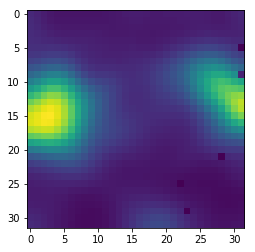

In [18]:
plt.imshow(ratemap)

## Grid Score

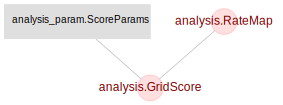

In [19]:
dj.Diagram(analysis.GridScore) - 1

In [20]:
analysis.GridScore.describe();

-> analysis.RateMap
-> analysis_param.ScoreParams
---
auto_corr            : longblob                     # 1
grid_score=null      : float                        # 2     score
grid_spacings        : longblob                     # 2     stats.spacing
grid_orientations    : longblob                     # 2     stats.orientations
grid_ellipse         : longblob                     # 2     stats.ellipse
grid_ellipse_theta=null : float                        # 2     stats.ellipseTheta
grid_ellipse_aspect_ratio=null : float                        # Not explicitly calculated in BNT



## Speed Score

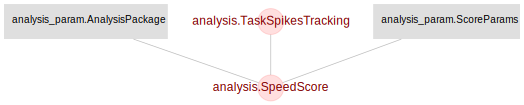

In [21]:
dj.Diagram(analysis.SpeedScore) - 1

In [22]:
analysis.SpeedScore.describe();

-> analysis.TaskSpikesTracking
-> analysis_param.ScoreParams
-> analysis_param.AnalysisPackage
---
speed_score          : float                        



## Angular Occupancy

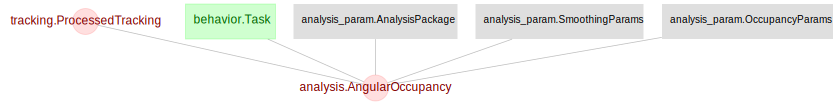

In [23]:
dj.Diagram(analysis.AngularOccupancy) - 1

In [24]:
analysis.AngularOccupancy.describe();

-> behavior.Task
-> tracking.ProcessedTracking
-> analysis_param.OccupancyParams
-> analysis_param.SmoothingParams
-> analysis_param.AnalysisPackage
---
angular_occupancy    : longblob                     # Smoothed 1D occupancy                        # tc(:,3)
angular_occupancy_raw : longblob                     # Raw, non-smoothed 1D occupancy               # Not explicitly output
angular_occupancy_mask : longblob                     # Mask (where count for that bin is 0) - ie animal never there # Not explicitly output
angle_coverage       : float                        # Fraction of angles that the animal covered   # Not explicitly output
angle_edges          : longblob                     # Histogram edges in radians                   # Not explicitly outouyt
angle_centers        : longblob                     # Histogram bin centers in radians             # tc(:, 1)



## Head Direction Tuning

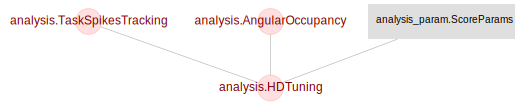

In [25]:
dj.Diagram(analysis.HDTuning) - 1

In [26]:
analysis.HDTuning.describe();

-> analysis.TaskSpikesTracking
-> analysis.AngularOccupancy
-> analysis_param.ScoreParams
---
hd_tuning            : longblob                     # Smoothed 1D ratemap              # 1 tc(:, 2)
hd_tuning_mask       : longblob                     # 1 isnan(tc(:,2))
hd_tuning_raw        : longblob                     # Raw, binned spikes               # Not explicitly calculated
hd_score=null        : float                        # head direction score     # 2 tcStat.score
hd_mvl=null          : float                        # mean vector length       # 2 tcStat.r
hd_mean_direction=null : float                        # in degrees               # 2 tcStat.mean
hd_peak_direction=null : float                        # Angle with peak rate      # 2 tcStat.peakDirection
hd_peak_rate=null    : float                        # Rate at peak angle        # 2 tcStat.peakRate
hd_stdev=null        : float                        # Angular standard deviation# Not explicitly calculated



In [27]:
analysis.HDTuning()

animal_id,datasource_id,session_time start time of this session,task_type,task_start (s) timestamp of task onset with respect to the start of the session,unit unit id,spike_tracking_hash hash of the SpikesTracking primary_key,cell_selection_params_name user-friendly name,tracking_time start time of this tracking recording,tracking_processing_method,sync_method sync method name,"occu_params_name Parameter set ID, starting with 'default'",smoothing_params_name,analysis_package,score_params_name,"hd_tuning Smoothed 1D ratemap # 1 tc(:, 2)","hd_tuning_mask 1 isnan(tc(:,2))","hd_tuning_raw Raw, binned spikes # Not explicitly calculated",hd_score head direction score # 2 tcStat.score,hd_mvl mean vector length # 2 tcStat.r,hd_mean_direction in degrees # 2 tcStat.mean,hd_peak_direction Angle with peak rate # 2 tcStat.peakDirection,hd_peak_rate Rate at peak angle # 2 tcStat.peakRate,hd_stdev Angular standard deviation# Not explicitly calculated
61fd2ac184c13c73,0,2017-10-02 15:54:25,OpenField,0.00,5006,8d40495f0a60f3f4aa26eb7a372aad94,default,2017-10-02 15:54:25,2d_2led,presync,default,default,python,default,=BLOB=,=BLOB=,=BLOB=,-1.0,0.057282,19.7535,232.5,34.1191,1.37311
61fd2ac184c13c73,0,2017-10-02 15:54:25,OpenField,0.00,5032,5e4c12537e345a3a63b71fbb8742b473,default,2017-10-02 15:54:25,2d_2led,presync,default,default,python,default,=BLOB=,=BLOB=,=BLOB=,-1.0,0.057282,94.4978,232.5,40.2014,1.37311
61fd2ac184c13c73,0,2017-10-02 15:54:25,OpenField,0.00,5036,c70f0242e203025599a89f22b2811405,default,2017-10-02 15:54:25,2d_2led,presync,default,default,python,default,=BLOB=,=BLOB=,=BLOB=,-1.0,0.057282,62.5222,232.5,117.116,1.37311
61fd2ac184c13c73,0,2017-10-02 15:54:25,OpenField,0.00,7009,1afa98dbade3501ebdfa5a211f50de75,default,2017-10-02 15:54:25,2d_2led,presync,default,default,python,default,=BLOB=,=BLOB=,=BLOB=,-1.0,0.057282,-128.712,232.5,172.164,1.37311
61fd2ac184c13c73,0,2017-10-02 15:54:25,OpenField,0.00,7023,80e139e0b7228efa17da141142c36eb9,default,2017-10-02 15:54:25,2d_2led,presync,default,default,python,default,=BLOB=,=BLOB=,=BLOB=,-1.0,0.057282,-82.3285,232.5,88.7127,1.37311


# =============================================================

# Extending the pipeline - construct downstream *Computed* table

Let's start with a simple task, in some hypothetical situation, let's say that for each ***brain_area*** in ***reference.BrainArea***, we want to
1. get the ***brain_area_description***
2. count the length of this ***brain_area_description***
3. store this length somewhere

In [28]:
reference.BrainArea()

brain_area,brain_area_description
HP - CA1,Subfield of hippocampus
HP - CA3,ubfield of hippocampus
HP - DG,
MEC - Layer 2,Superficial layer of the medial-entorhinal cortex
MEC - Layer 3,Superficial layer of the medial-entorhinal cortex


Obviously the most straight forward strategy would be to loop through each entry in ***reference.BrainArea***, fetch the ***brain_area_description***, and get the length

In [29]:
for brain_area_key in reference.BrainArea.fetch('KEY'):
    desc = (reference.BrainArea & brain_area_key).fetch1('brain_area_description')
    l = len(desc)
    print(l)

23
22
0
49
49
42
42
0


Let's say we feel extra fancy and make a ***Computed*** table to store this new description string, let's see how that can be done. An example template of this computed table would look something like this:
```python
@schema
class BrainAreaDescLength(dj.Computed):
    definition = """
    -> reference.BrainArea
    ---
    desc_length: int
    """
    
    def make(self, key):
        # implementation goes here
```

The `definition` portion is a string specifying the structure/blue-print of the table:

Here, we design this ***BrainAreaDescLength*** to contain a single primary attribute, a foreign key referencing the ***reference.BrainArea***

In other words, we design this ***BrainAreaDescLength*** table to only depend on one upstream parent table: ***reference.BrainArea***, and no additional primary attributes

Meaning this is one-to-one mapping, there will be only one entry in ***BrainAreaDescLength*** corresponding to each entry in ***reference.BrainArea***

`make()` is a method that get invoked for every newly available parent(s) that not yet processed. The job of the `make()` is to:
1. retrieve the data from the parent(s) - ideally just the pieces you need, not all
2. perform some computation based on the retrieved data
3. write the computed results to this table

Ok, let's actually implement this,

first off, what is that `@schema` thing, `schema` is a variable storing the information to tell DataJoint which ***schema*** in the database to create this new table ***BrainAreaDescLength*** in

In [30]:
schema = dj.schema('user_thinh_new_analysis')

In [39]:
@schema
class BrainAreaDescLength(dj.Computed):
    definition = """
    -> reference.BrainArea
    ---
    desc_length: int
    """
    
    def make(self, key):
        
        # ==== Retrieve inputs from upstream - fetch() ====
        desc = (reference.BrainArea & key).fetch1('brain_area_description')
        
        # ==== Perform computation ====
        l = len(desc)
        print(key)
        print(l)
        print('')
        
        # ==== Write outputs to this table ====
        key['desc_length'] = l
        self.insert1(key)

In the `make()` we can then specify the code to perform the computation, just as above, but no need for the for-loop, ***DataJoint*** will take care of that, let's see how.

In [40]:
BrainAreaDescLength()

brain_area,desc_length


So now we have the table setup, with the `make()` method implemented, how to actually perform the computation? 

That's is achieved with the `.populate()` call

In [41]:
BrainAreaDescLength.populate()

{'brain_area': 'HP - CA1'}
23

{'brain_area': 'HP - CA3'}
22

{'brain_area': 'HP - DG'}
0

{'brain_area': 'MEC - Layer 2'}
49

{'brain_area': 'MEC - Layer 3'}
49

{'brain_area': 'MEC - Layer 5'}
42

{'brain_area': 'MEC - Layer 6'}
42

{'brain_area': 'unknown'}
0



In [42]:
BrainAreaDescLength()

brain_area,desc_length
HP - CA1,23
HP - CA3,22
HP - DG,0
MEC - Layer 2,49
MEC - Layer 3,49


## With parameters?

Let's take one step further, let's say we want to take the newly computed ***desc_length***, multiply by some parameterizable factor, and store the product

In [43]:
@schema
class DescLengthFactor(dj.Lookup):
    definition = """
    desc_multiplier: int
    """
    
    contents = zip([-1, 2])

***DescLengthFactor*** is a ***Lookup*** table, this just means that this table typically contains some predefined values upon creation (`contents`), and adding of new values typically do not occur very often (certainly not on a daily basis).
An example would be ***reference.RecordingSystem***

(let maybe add another multiplier, say 10)

Now, back to the ***Computed*** table

In [44]:
@schema
class ProcessedDescLength(dj.Computed):
    definition = """
    -> BrainAreaDescLength
    -> DescLengthFactor
    ---
    scaled_desc_length: int
    """
    
    def make(self, key):
        
        # ==== Retrieve inputs from upstream - fetch() ====
        desc_length = (BrainAreaDescLength & key).fetch1('desc_length')
        multiplier = (DescLengthFactor & key).fetch1('desc_multiplier')
        
        # ==== Perform computation ====
        scaled_length = desc_length * multiplier
        print(key)
        print(scaled_length)
        print('')
        
        # ==== Write outputs to this table ====
        key['scaled_desc_length'] = scaled_length
        self.insert1(key)

In [45]:
ProcessedDescLength()

brain_area,desc_multiplier,scaled_desc_length


call `.populate()` on this

In [46]:
ProcessedDescLength.populate()

{'brain_area': 'HP - CA1', 'desc_multiplier': -1}
-23

{'brain_area': 'HP - CA1', 'desc_multiplier': 2}
46

{'brain_area': 'HP - CA3', 'desc_multiplier': -1}
-22

{'brain_area': 'HP - CA3', 'desc_multiplier': 2}
44

{'brain_area': 'HP - DG', 'desc_multiplier': -1}
0

{'brain_area': 'HP - DG', 'desc_multiplier': 2}
0

{'brain_area': 'MEC - Layer 2', 'desc_multiplier': -1}
-49

{'brain_area': 'MEC - Layer 2', 'desc_multiplier': 2}
98

{'brain_area': 'MEC - Layer 3', 'desc_multiplier': -1}
-49

{'brain_area': 'MEC - Layer 3', 'desc_multiplier': 2}
98

{'brain_area': 'MEC - Layer 5', 'desc_multiplier': -1}
-42

{'brain_area': 'MEC - Layer 5', 'desc_multiplier': 2}
84

{'brain_area': 'MEC - Layer 6', 'desc_multiplier': -1}
-42

{'brain_area': 'MEC - Layer 6', 'desc_multiplier': 2}
84

{'brain_area': 'unknown', 'desc_multiplier': -1}
0

{'brain_area': 'unknown', 'desc_multiplier': 2}
0



In [47]:
ProcessedDescLength()

brain_area,desc_multiplier,scaled_desc_length
HP - CA1,-1,-23
HP - CA1,2,46
HP - CA3,-1,-22
HP - CA3,2,44
HP - DG,-1,0


The ***ProcessedDescLength*** contains 2 primary attributes: ***brain_area*** and ***desc_multiplier***, thus any ***scaled_desc_length*** can always be traced back to which ***BrainAreaDescLength*** and ***DescLengthFactor*** it's being computed from.

And from ***BrainAreaDescLength*** we certainly can trace back to ***BrainArea***

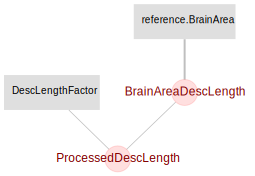

In [48]:
dj.Diagram(schema) - 1

## `make()` for the GridScore table

Now, for a more realistic example, let's take a look at the full code to build the ***analysis.GridScore*** table

```python
@schema
class GridScore(dj.Computed):
    definition = """
    -> RateMap
    -> analysis_param.ScoreParams
    ---
    auto_corr                       : longblob      # 1
    grid_score=null                  : float        # 2     score
    grid_spacings                   : longblob      # 2     stats.spacing
    grid_orientations               : longblob      # 2     stats.orientations
    grid_ellipse                    : longblob      # 2     stats.ellipse
    grid_ellipse_theta=null          : float        # 2     stats.ellipseTheta
    grid_ellipse_aspect_ratio=null   : float        # Not explicitly calculated in BNT
    """

    def make(self, key):
        
        # ==== Retrieve inputs from upstream - fetch() ====
        rmap, mask = (RateMap & key).fetch1("ratemap", "ratemap_mask")
        rmap = np.ma.masked_where(mask, rmap)
        acorr = opexebo.analysis.autocorrelation(rmap)
        
        # ==== Perform computation ====
        search_method = (analysis_param.FieldDetectParams & key).fetch1("search_method")
        min_orient = (analysis_param.ScoreParams & key).fetch1("min_orientation")
        grid_score, grid_stats = opexebo.analysis.grid_score(acorr, 
                                                             search_method=search_method,
                                                             min_orientation=min_orient)
        
        # ==== Write outputs to this table - insert() ==== 
        to_input = {"auto_corr": acorr, "grid_score": grid_score, **grid_stats}
        self.insert1({**key, **to_input}, ignore_extra_fields=True)
        
```

Again, the logic in `make()` typically follow:
1. Fetch the relevant data from upstream for the computation
2. Peform the computation - typically calling another method, package elsewhere
3. Insert the results into the table

# Exercise

As an example exercise, let's build a new ***Computed*** table to extract the ***ratemap*** from each ***analysis.RateMap***, and computed to x, y location of the peak rate

In [49]:
analysis.RateMap()

animal_id,datasource_id,session_time start time of this session,task_type,task_start (s) timestamp of task onset with respect to the start of the session,unit unit id,spike_tracking_hash hash of the SpikesTracking primary_key,cell_selection_params_name user-friendly name,tracking_time start time of this tracking recording,tracking_processing_method,sync_method sync method name,"occu_params_name Parameter set ID, starting with 'default'",smoothing_params_name,analysis_package,"field_detect_params_name Field detection method name, starting with A",ratemap Smoothed 2D ratemap # 1 map.z,ratemap_mask Mask (where time = 0) # 1 isnan(map.zRaw),ratemap_raw Unsmoothed ratemap # 1 map.zRaw,fieldmap 2 fieldsMap,field_quantity 2 size(fields),peak_rate,mean_rate 4,spatial_information_rate 3 information.rate,spatial_information_content 3 information.content,spatial_coherence 5 coherence,selectivity 3 selectivity,sparsity 5 sparsity
61fd2ac184c13c73,0,2017-10-02 15:54:25,OpenField,0.00,5006,8d40495f0a60f3f4aa26eb7a372aad94,default,2017-10-02 15:54:25,2d_2led,presync,default,default,python,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,0,2.84479,1.63283,0.275918,0.163977,0.0785802,1.69065,0.94691
61fd2ac184c13c73,0,2017-10-02 15:54:25,OpenField,0.00,5032,5e4c12537e345a3a63b71fbb8742b473,default,2017-10-02 15:54:25,2d_2led,presync,default,default,python,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,2,12.1481,2.02863,0.892813,0.442599,0.335917,6.02225,0.717738
61fd2ac184c13c73,0,2017-10-02 15:54:25,OpenField,0.00,5036,c70f0242e203025599a89f22b2811405,default,2017-10-02 15:54:25,2d_2led,presync,default,default,python,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,7,18.5686,5.35808,2.60488,0.450387,0.604888,3.21053,0.745056
61fd2ac184c13c73,0,2017-10-02 15:54:25,OpenField,0.00,7009,1afa98dbade3501ebdfa5a211f50de75,default,2017-10-02 15:54:25,2d_2led,presync,default,default,python,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,8,13.5018,7.83935,1.02886,0.129347,0.226597,1.69744,0.960593
61fd2ac184c13c73,0,2017-10-02 15:54:25,OpenField,0.00,7023,80e139e0b7228efa17da141142c36eb9,default,2017-10-02 15:54:25,2d_2led,presync,default,default,python,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,5,7.93165,4.11562,0.559719,0.134315,0.250724,1.90334,0.958348


In [50]:
ratemap =  (analysis.RateMap & 'session_time = "2018-01-02 11:20:23"' & 'unit = 5019').fetch1('ratemap')

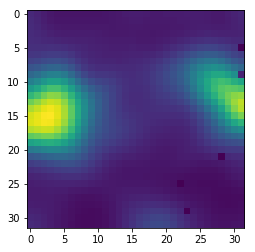

In [51]:
plt.imshow(ratemap)

In [52]:
y, x = np.unravel_index(np.argmax(ratemap), ratemap.shape)

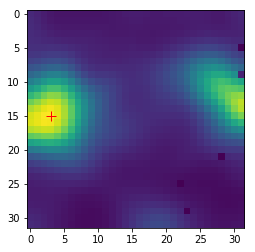

In [53]:
plt.imshow(ratemap)
plt.plot(x, y, '+r', markersize=10)

In [ ]:
schema = dj.schema('user_thinh_new_analysis')

@schema
class RateMapPeakPosition(dj.Computed):
    definition = """
    
    # (fill in the blank...)
    
    """
    
    def make(self, key):
        
        # fill in the blank ...

Five hours later...

### Optional points:
+ delete
+ look at the newly built schema (Diagram)
+ drop table
+ drop schema

# ===========================================================

(if time permits)

# Cell Analysis Method

## Recap on the analysis pipeline

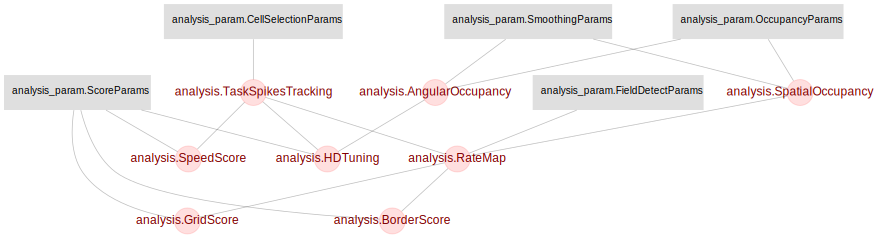

In [69]:
dj.Diagram(analysis.TaskSpikesTracking) + 2 + analysis.SpatialOccupancy + analysis.AngularOccupancy - analysis.ShuffledScores - analysis.RateMap.FiringFields - analysis.ScoreSummary + analysis_param.CellSelectionParams + analysis_param.FieldDetectParams + analysis_param.OccupancyParams + analysis_param.ScoreParams + analysis_param.SmoothingParams

The analysis tables are parameterized by multiple set of parameters. Give this, we can easily imaging how the combination of different parameter sets can get overwhelmingly large.  

More importantly, for example, I don't necessarily want my set of clustering results to be processed by all possible combination of parameters, just one set of parameter, the one I always use.

To that, we demonstrate here a set of "utility" tables to control this behavior: ***CellAnalysisMethod***

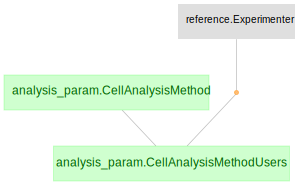

In [72]:
dj.Diagram(analysis_param.CellAnalysisMethod) + analysis_param.CellAnalysisMethodUsers + reference.Experimenter

In [73]:
analysis_param.CellAnalysisMethod()

cell_analysis_method,cell_analysis_method_hash hash of the dictionary of the part params: with key as the table name (e.g. OccupancyParams) and value as the corresponding param hash (e.g. occu_params_hash),cell_analysis_description
method_default,d36a981bb53fd79b8e4fa03e8cd5c448,


Each ***Cell Analysis Method*** contains:
+ CellSelectionParams
+ FieldDetectParams
+ OccupancyParams
+ ScoreParams
+ ShuffleParams
+ SmoothingParams

***One*** choice of each

Sufficient to allow for complete computation of all the analysis tables

Each ***Cell Analysis Method*** can have multiple associated ***method users***. And for a particular set of ***CuratedClustering*** result, the analysis pipeline will execute using the parameters from the ***Cell Analysis Method*** that the ***curator*** is one of the ***method users***